# FastICA implementation

## 0. Environment setup

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from sklearn.decomposition import FastICA

from fast_ica import fast_ica

np.random.seed(42)


## 1. Signal creation
In this section we create the original signals (3 components):

- a sinusoidal wave;
- a square wave;
- a sawtooth wave.

In particular, we will have 3 components made up by 1000 samples each.

In [2]:
def sine_wave(time: np.ndarray, amp: float, freq: float, phase: float) -> np.ndarray:
    return amp * np.sin(2 * np.pi * freq * time + phase)

def square_wave(time: np.ndarray, amp: float, freq: float, phase: float) -> np.ndarray:
    return amp * signal.square(2 * np.pi * freq * time + phase)

def sawtooth_wave(time: np.ndarray, amp: float, freq: float, phase: float) -> np.ndarray:
    return amp * signal.sawtooth(2 * np.pi * freq * time + phase)

In [3]:
t = np.linspace(0, 10, 1000)

# Matrix S with the original signals (n_components, n_samples)
S = np.vstack([
    sine_wave(t, amp=1.5, freq=0.3, phase=np.pi),
    square_wave(t, amp=1, freq=0.5, phase=0),
    sawtooth_wave(t, amp=0.5, freq=0.7, phase=-np.pi)
])
# S += 0.2 * np.random.normal(size=S.shape)  # noise

Then, we generate the random mixing matrix A: we multiply it by S to obtain the observations X, namely the mixed signals.

In [4]:
# Mixing matrix A
A = np.array([[1, 1, 1], [0.5, 2, 1], [1.5, 1, 2]])  # Mixing matrix
print(A)

# Observations X (n_components, n_samples)
X = np.matmul(A, S)

[[1.  1.  1. ]
 [0.5 2.  1. ]
 [1.5 1.  2. ]]


In [5]:
my_S = fast_ica(X, strategy="parallel")

[[-0.41364717  0.0504503   0.48412992]
 [ 0.04511406  0.22647107  0.40425901]
 [ 0.44931904  0.3676501   0.19905471]]

[[-0.34179948  0.03255233  0.40690414]
 [ 0.04355191  0.21775957  0.39196724]
 [ 0.42944695  0.3092018   0.18895665]]


IndexError: 

## 2. FastICA
Through the FastICA algorithm, implemented in the `fast_ica` function imported before, we estimate W, the inverse of the mixing matrix, and then S (by multiplying W with the observations).
The observations must be preprocessed by centering and whitening (already implemented in the function).

In [5]:
my_S = fast_ica(X, strategy="deflation")

As a comparison, we will test the output of `sklearn` implementation of FastICA.

In [6]:
ica = FastICA(n_components=3, algorithm="deflation")
sk_S = ica.fit_transform(X.T).T

Now let's plot all the signals.

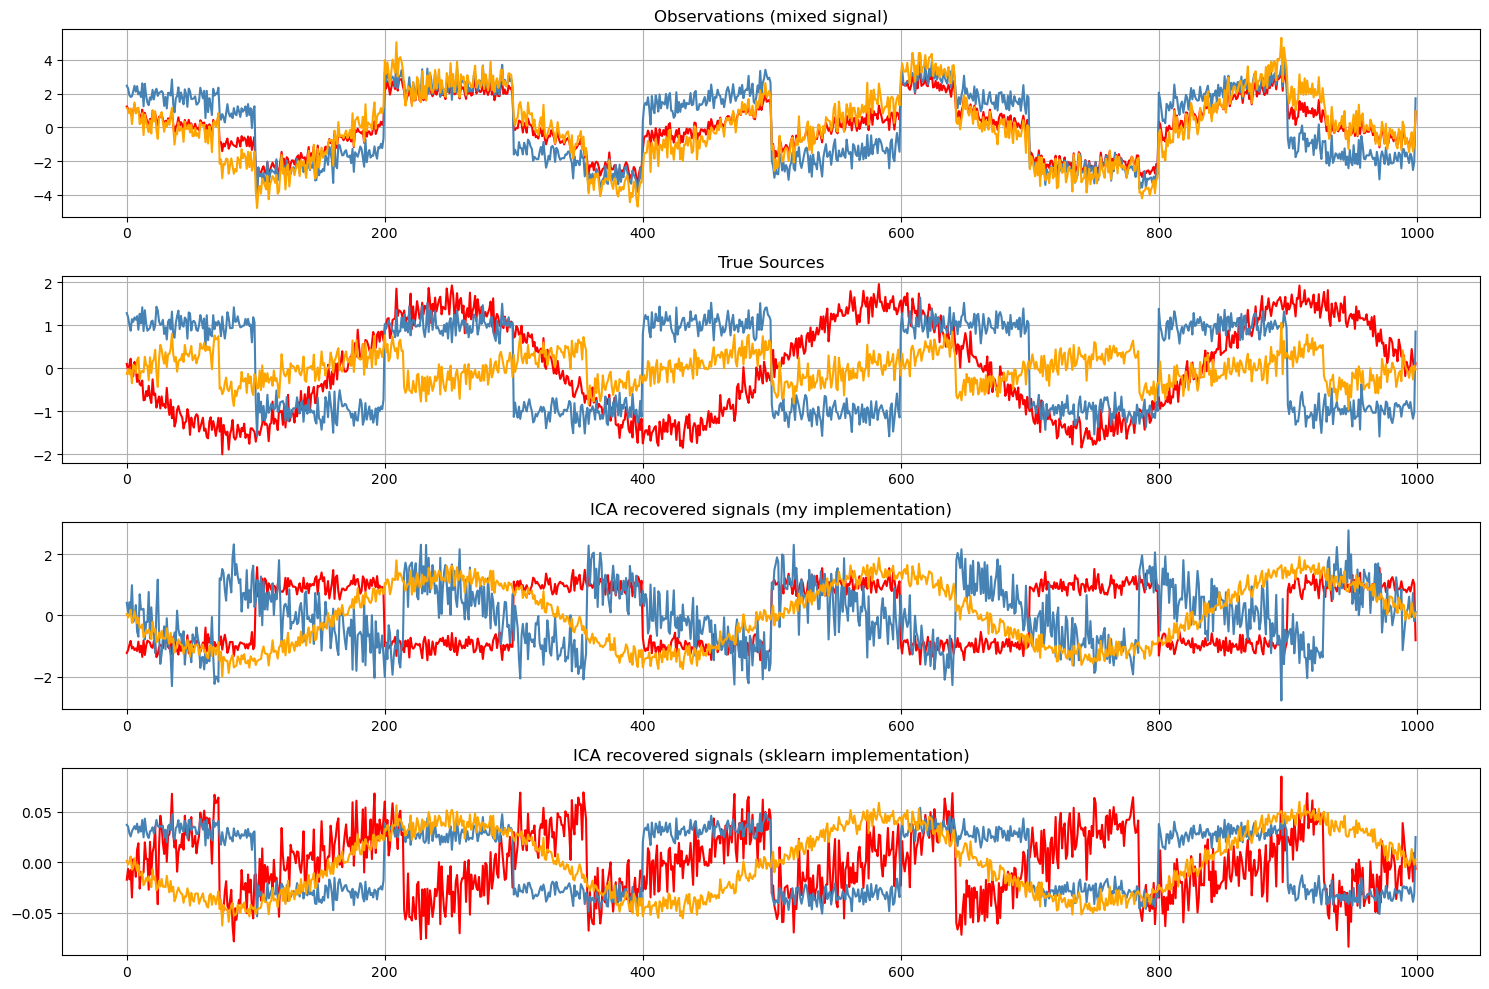

In [7]:
plt.figure(figsize=(15, 10))

models = [X, S, my_S, sk_S]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals (my implementation)',
         'ICA recovered signals (sklearn implementation)']
colors = ['red', 'steelblue', 'orange']
plots = len(models)

for ii, (model, name) in enumerate(zip(models, names)):
    plt.subplot(plots, 1, ii + 1)
    plt.title(name)
    plt.plot(model[0], color=colors[0])
    plt.plot(model[1], color=colors[1])
    plt.plot(model[2], color=colors[2])
    plt.grid()
    
plt.tight_layout()
plt.show()

## 3. Deflation vs parallel
In the `fast_ica` implementation, there are two strategies:

- deflation, which computes each unit sequentially and accumulates the error;
- parallel, which computes each unit in parallel and averages the error.

Let's compare the execution time of both.

In [8]:
%%timeit -n 1000

fast_ica(X, strategy="deflation")

1.55 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%%timeit -n 1000

fast_ica(X, strategy="parallel")

1.25 ms ± 68.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


As it can be seen, the parallel version is slightly faster. When the number of components increases, the performance gap should also increase.

Let's now plot both the results of the deflation and parallel implementations.

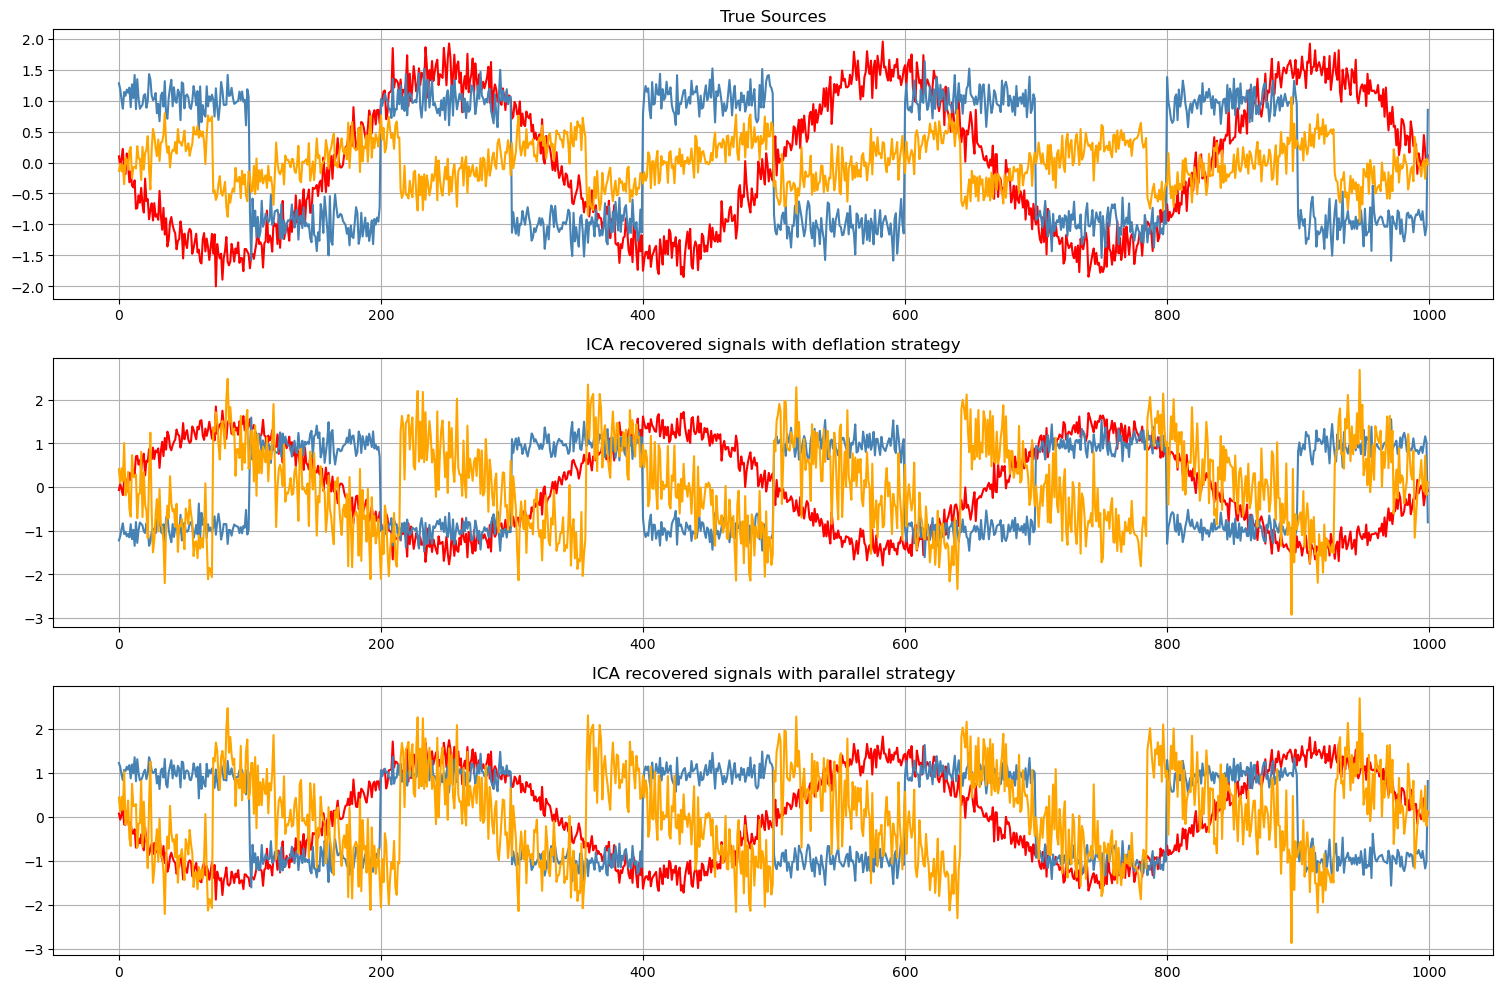

In [10]:
S_def = fast_ica(X, strategy="deflation")
S_sym = fast_ica(X, strategy="parallel")

plt.figure(figsize=(15, 10))

models = [S, S_def, S_sym]
names = ['True Sources',
         'ICA recovered signals with deflation strategy',
         'ICA recovered signals with parallel strategy']
colors = ['red', 'steelblue', 'orange']
plots = len(models)

for ii, (model, name) in enumerate(zip(models, names)):
    plt.subplot(plots, 1, ii + 1)
    plt.title(name)
    plt.plot(model[0], color=colors[0])
    plt.plot(model[1], color=colors[1])
    plt.plot(model[2], color=colors[2])
    plt.grid()
    
plt.tight_layout()
plt.show()